# Preliminary: Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler


In [2]:
filename=r'HW3_data.csv'
df = pd.read_csv(filename)
train, test=train_test_split(df,test_size=0.2,train_size=0.8,random_state=106)

data normalization:

In [3]:
def split_and_create_columns(data):
  temp=pd.get_dummies(data.blood_type)
  data["A blood_type"]=temp['A+']+temp['A-']
  data["B or AB blood_type"]=temp['AB+']+temp['AB-']+temp['B-']+temp['B+']
  data["O blood_type"]=temp['O+']+temp['O-']
  temp=pd.get_dummies(data.symptoms)
  temp=temp.loc[:, ['smell_loss','cough;shortness_of_breath;sore_throat']]
  data = pd.concat([data, temp],axis=1)
  data['pcr_date'] = pd.to_datetime(data['pcr_date']).astype(int)
  data['sex']=np.where(data['sex']=='F',1,0)
  data[['Latitude','Longitude']] = data['current_location'].str.split(',', expand=True)
  data['Latitude']=data.Latitude.str.strip('(')
  data['Latitude']=data.Latitude.str.strip("'")
  data['Latitude']=data.Latitude.astype(float)
  data['Longitude']=data.Longitude.str.strip(')')
  data['Longitude']=data.Longitude.str.strip()
  data['Longitude']=data.Longitude.str.strip("'")
  data['Longitude'] = data['Longitude'].astype(float)
  return data


def prepare_data(training_data, new_data):
  training_data_c=training_data.copy(deep=True)
  new_data_c=new_data.copy(deep=True)
  training_data_c=split_and_create_columns(training_data_c)
  new_data_c=split_and_create_columns(new_data_c)
  for column in training_data_c:
    if(column=='age' or column=='Latitude' or column=='Longitude' or column=='num_of_siblings' or column=='happiness_score' or column=='household_income' or column=='sugar_levels' or column=='weight' or column=='PCR_04' or column=='PCR_05' or column=='PCR_06' or column=='PCR_10'):
      new_data_c[column]=(new_data_c[column]-training_data_c[column].mean())/training_data_c[column].std()
    if(column=='conversations_per_day' or column=='sport_activity' or column=='pcr_date' or column=='PCR_01' or column=='PCR_01' or column=='PCR_02' or column=='PCR_03' or column=='PCR_07' or column=='PCR_08' or column=='PCR_09'):
      new_data_c[column]=(new_data_c[column]-training_data_c[column].min())/(training_data_c[column].max()-training_data_c[column].min())
      new_data_c[column]=new_data_c[column]*2+(-1)
  return new_data_c[['age','sex','weight','A blood_type', 'B or AB blood_type', 'O blood_type', 'Latitude', 'Longitude', 'num_of_siblings',
 'happiness_score','household_income','conversations_per_day','sugar_levels','sport_activity','smell_loss',
 'cough;shortness_of_breath;sore_throat','pcr_date','PCR_01','PCR_02','PCR_03','PCR_04','PCR_05','PCR_06','PCR_07',
 'PCR_08','PCR_09','PCR_10','contamination_level']]

In [4]:
test=prepare_data(train,test)
train=prepare_data(train,train)

# Section 1: Linear regression implementation

> Indented block



Q1:

In [137]:
import pdb

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        loss = (np.linalg.norm(((X.dot(w)+b).reshape(-1)-y))**2)/(y.size)

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        g_w = ((X.transpose()).dot(((X.dot(w)+b).reshape(-1)-y)))/(0.5*y.size)
        g_b = (((X.dot(w)+b).reshape(-1)-y).sum())/(0.5*y.size)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w,self.b,batch_X,batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr*g_w
            self.b = self.b - self.lr*g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = (X.dot(self.w) + self.b).reshape(-1)

        return y_pred

Q2:

In [138]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


In [139]:
t_sub, v_sub=train_test_split(train,test_size=0.2,train_size=0.8,random_state=106)


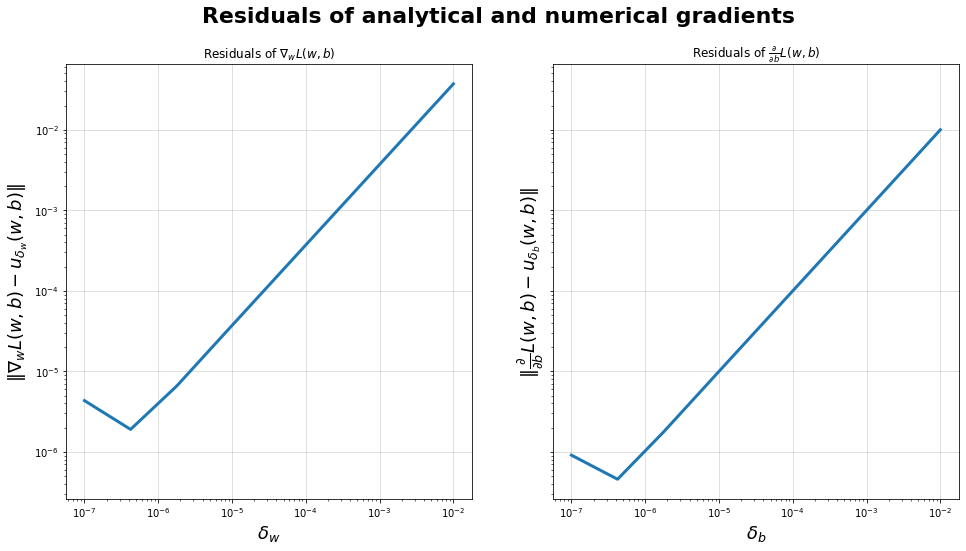

In [140]:
X_train=t_sub.iloc[:,0:-1].values
y_train=t_sub['contamination_level'].values
compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))


Q3:

In [141]:
import numpy as np
def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 395.46291527712185, Best validation loss = 429.4309431178816
lr size = 1e-08, Best train loss = 395.42314135190236, Best validation loss = 429.38857467251177
lr size = 1e-07, Best train loss = 395.0256952062266, Best validation loss = 428.9651962811767
lr size = 1e-06, Best train loss = 391.08039879932863, Best validation loss = 424.76186857618063
lr size = 1e-05, Best train loss = 354.4036364803476, Best validation loss = 385.6296008235379
lr size = 0.0001, Best train loss = 165.25440109723678, Best validation loss = 181.04906087605738
lr size = 0.001, Best train loss = 90.21046160739702, Best validation loss = 99.12826067293814
lr size = 0.01, Best train loss = 85.14919904959072, Best validation loss = 93.07025210019466
lr size = 0.1, Best train loss = 86.0979196125667, Best validation loss = 89.79428004985124


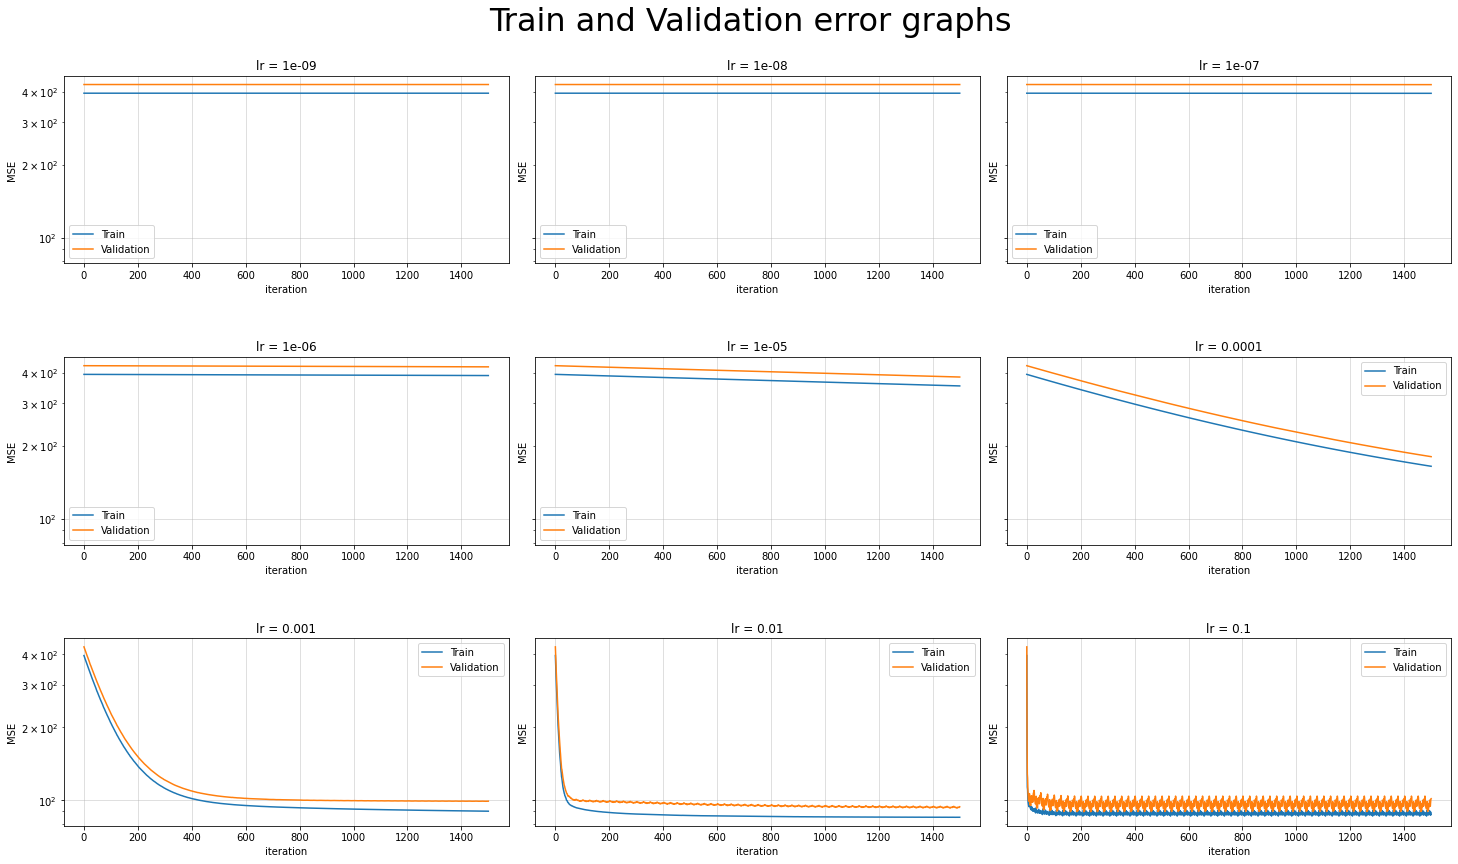

In [142]:
X_val=v_sub.iloc[:,0:-1].values
y_val=v_sub['contamination_level'].values
test_lr(X_train, y_train, X_val, y_val,'Train and Validation error graphs')

# Section 2: Evaluation and Baseline

Q4:

In [154]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
X=train.iloc[:,0:-1].values
y=train['contamination_level'].values
dummy_regr.fit(X,y)
scores = cross_validate(dummy_regr, X, y, cv=5,scoring=('neg_mean_squared_error'), return_train_score=True)
train_scores=np.absolute(scores['train_score'])
test_scores=np.absolute(scores['test_score'])
np.mean(train_scores)

98.61115519140205

In [155]:
np.mean(test_scores)

98.76617111200476

retraining for section 6:

In [156]:
dummy_regr.fit(X,y)


DummyRegressor()

Q5:

In [159]:
training_score=[]
validation_score=[]
min_lr=100
min_train_lr=0
best=0
for lr in np.logspace(np.log2(0.0001),np.log2(0.2),30,base=2):
  reg=LinearRegressor(lr)
  score=cross_validate(reg,X,y,cv=5,return_train_score=True,scoring='neg_mean_squared_error')
  training_score.append(score['train_score'].mean())
  validation_score.append(score['test_score'].mean())
  if(np.absolute(score['test_score'].mean())<min_lr):
    min_lr=score['test_score'].mean()
    min_train_lr=score['train_score'].mean()
    best=lr

Text(0.5, 1.0, 'training and validation scores according to lr')

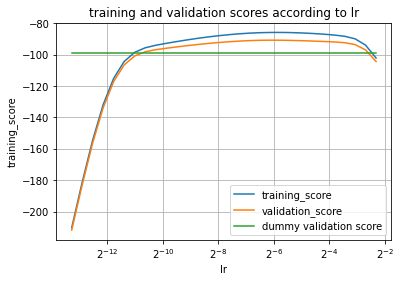

In [158]:
space=np.logspace(np.log2(0.0001),np.log2(0.2),30,base=2)
val_dummy=np.array([-np.mean(test_scores)]*space.size)
data={'lr':space,'training_score':training_score,'validation_score':validation_score,'dummy validation score':val_dummy}
df1=pd.DataFrame(data)
sns.lineplot(data=df1,x='lr',y='training_score',label='training_score')
sns.lineplot(data=df1,x='lr',y='validation_score',label='validation_score')
sns.lineplot(data=df1,x='lr',y='dummy validation score',label='dummy validation score')
plt.semilogx(base=2,data=space)
plt.grid()
plt.title("training and validation scores according to lr")

retraining regressor for part 6

In [150]:
reg=LinearRegressor(best)
reg.fit(X,y)

LinearRegressor(lr=0.0006263258605481301)

# Section 3: Ridge linear regression

In [161]:
from sklearn.linear_model import Ridge
label = 'contamination_level'
X_train = train.drop(columns=['contamination_level'])
Y_train = train[label]
param_space = np.logspace(-1, 3.5, 30)
test_scores = []
train_scores = []
for alpha in param_space:
    estimator = Ridge(alpha)
    scores = cross_validate(estimator, X_train, Y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
    test_scores.append(np.mean(scores['test_score']))
    train_scores.append(np.mean(scores['train_score']))

Optimal alpha: 88.7719708898587, validation score: -90.05872633497768, train score: -86.05573287389373


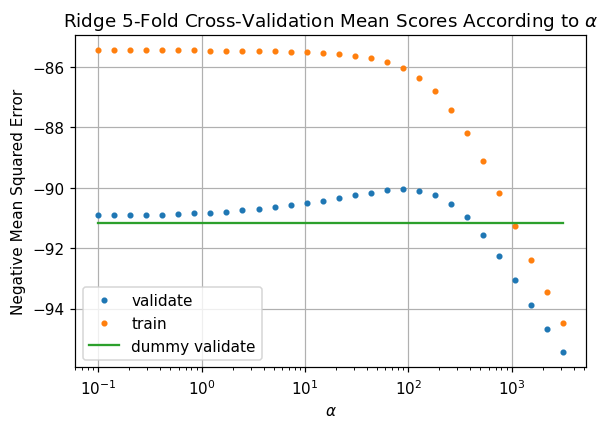

In [162]:
best_i = np.argmax(test_scores)
print(f"Optimal alpha: {param_space[best_i]}, validation score: {test_scores[best_i]}, train score: {train_scores[best_i]}")

plt.figure(dpi=110)
plt.plot(param_space, test_scores, '.', label='validate')
plt.plot(param_space, train_scores, '.', label='train')
plt.plot(param_space, np.ones(len(param_space))*np.mean(test_scores), '-', label='dummy validate')
plt.xlabel(r'$\alpha$')
plt.ylabel('Negative Mean Squared Error')
plt.title(r'Ridge 5-Fold Cross-Validation Mean Scores According to $\alpha$')
plt.semilogx()
plt.grid()
plt.legend()
plt.show()

In [133]:
best_ridge = Ridge(alpha=param_space[best_i])
best_ridge.fit(X_train, Y_train)

Ridge(alpha=88.7719708898587)

Top 5 features: PCR_01 sugar_levels sport_activity conversations_per_day cough;shortness_of_breath;sore_throat


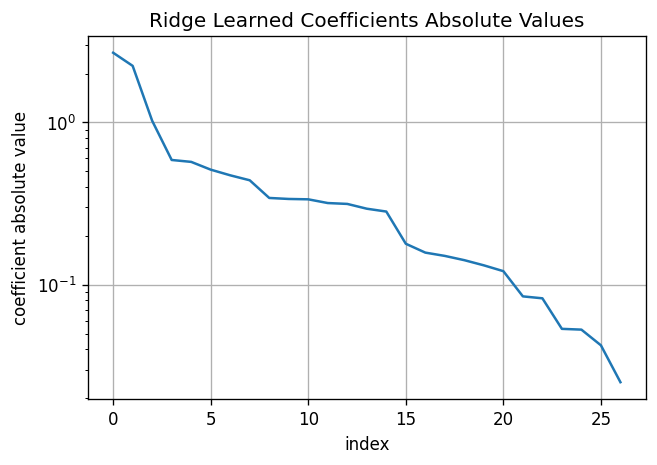

In [21]:
w = best_ridge.coef_
sorting = np.argsort(np.abs(w))[::-1]
sorted_w = np.abs(w[sorting])

print(f'Top 5 features: {X_train.columns[sorting[0]]} {X_train.columns[sorting[1]]} {X_train.columns[sorting[2]]} {X_train.columns[sorting[3]]} {X_train.columns[sorting[4]]}')

plt.figure(dpi=120)
plt.plot(np.arange(len(sorted_w)), sorted_w)
plt.grid()
plt.xlabel('index')
plt.ylabel('coefficient absolute value')
plt.yscale('log')
plt.title('Ridge Learned Coefficients Absolute Values')
plt.show()

# Section 4: Polynomial fitting (visualization)

In [118]:
train4=train[['PCR_01','PCR_05','contamination_level']].copy(deep=True)


In [119]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

/tmp/ipykernel_435/1706415936.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


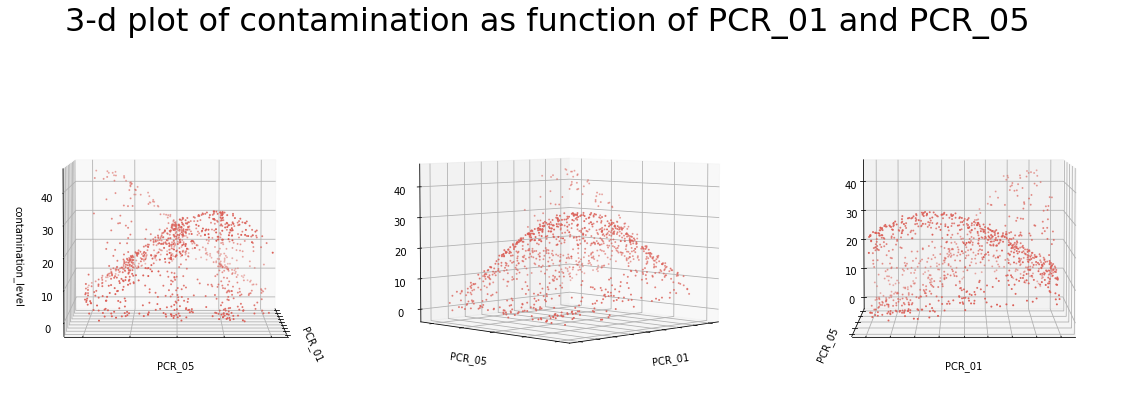

In [120]:
plot3d(train4,'PCR_01','PCR_05','contamination_level','3-d plot of contamination as function of PCR_01 and PCR_05')

In [121]:
X=train4[['PCR_01','PCR_05']].values
y=train4[['contamination_level']].values
space=np.logspace(np.log2(10**-12),np.log2(10**12),100,base=2)
training_score=[]
validation_score=[]
min_lr=100
best=0
for lamda in space:
  reg=Ridge(alpha=lamda,fit_intercept=True)
  reg.fit(X,y)
  score=cross_validate(reg,X,y,cv=5,return_train_score=True,scoring='neg_mean_squared_error')
  training_score.append(score['train_score'].mean())
  validation_score.append(score['test_score'].mean())
  if(np.absolute(score['test_score'].mean())<min_lr):
    min_lr=score['test_score'].mean()
    best=lamda

Text(0.5, 1.0, 'training and validation scores according to lr')

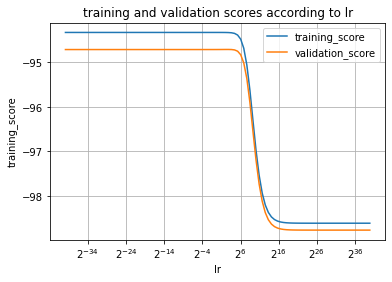

In [122]:
data={'lr':space,'training_score':training_score,'validation_score':validation_score}
df1=pd.DataFrame(data)
sns.lineplot(data=df1,x='lr',y='training_score',label='training_score')
sns.lineplot(data=df1,x='lr',y='validation_score',label='validation_score')
plt.semilogx(base=2,data=space)
plt.grid()
plt.title("training and validation scores according to lr")

In [123]:
reg=Ridge(alpha=best,fit_intercept=True)
reg.fit(X,y)
predictions_reg=reg.predict(X)

/tmp/ipykernel_29270/1706415936.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


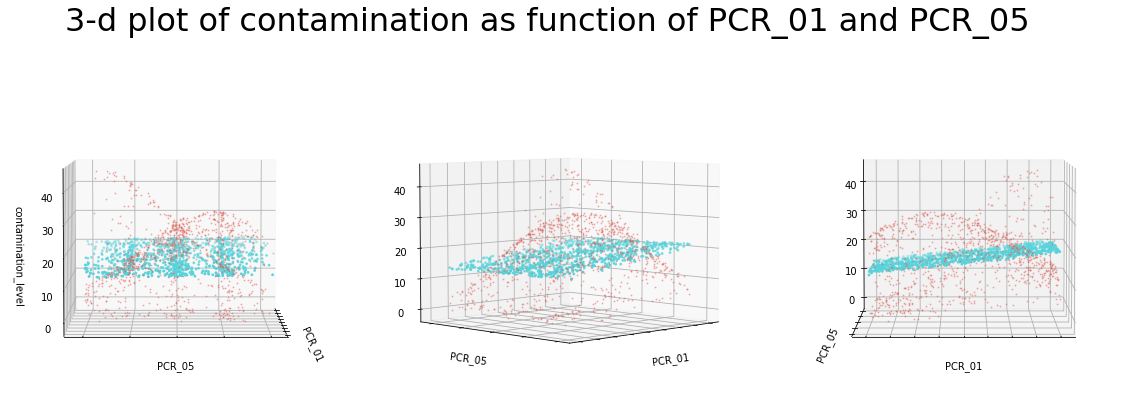

In [28]:
plot3d(train4,'PCR_01','PCR_05','contamination_level','3-d plot of contamination as function of PCR_01 and PCR_05',predictions=predictions_reg)

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(3)),
('normalization', MinMaxScaler(feature_range=(-1,1))),
('Ridge', Ridge(alpha=best, fit_intercept=True))])


In [126]:
space=np.logspace(np.log2(10**-12),np.log2(10**12),100,base=2)
training_score=[]
validation_score=[]
min_lr=100
best=0
for lamda in space:
  poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(3)),
('normalization', MinMaxScaler(feature_range=(-1,1))),
('Ridge', Ridge(alpha=lamda, fit_intercept=True))])
  score=cross_validate(poly_reg,X,y,cv=5,return_train_score=True,scoring='neg_mean_squared_error')
  training_score.append(score['train_score'].mean())
  validation_score.append(score['test_score'].mean())
  if(np.absolute(score['test_score'].mean())<min_lr):
    min_lr=score['test_score'].mean()
    best=lamda

Text(0.5, 1.0, 'training and validation scores according to lr')

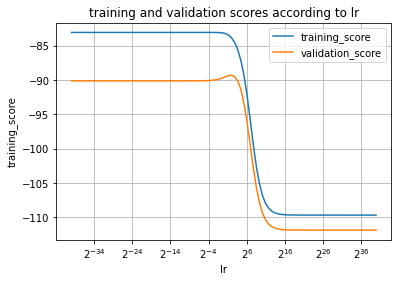

In [127]:
data={'lr':space,'training_score':training_score,'validation_score':validation_score}
df1=pd.DataFrame(data)
sns.lineplot(data=df1,x='lr',y='training_score',label='training_score')
sns.lineplot(data=df1,x='lr',y='validation_score',label='validation_score')
plt.semilogx(base=2,data=space)
plt.grid()
plt.title("training and validation scores according to lr")

In [129]:
poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(3)),
('normalization', MinMaxScaler(feature_range=(-1,1))),
('Ridge', Ridge(alpha=best, fit_intercept=True))])
poly_reg.fit(X,y)
predictions_reg=reg.predict(X)


/tmp/ipykernel_29270/1706415936.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


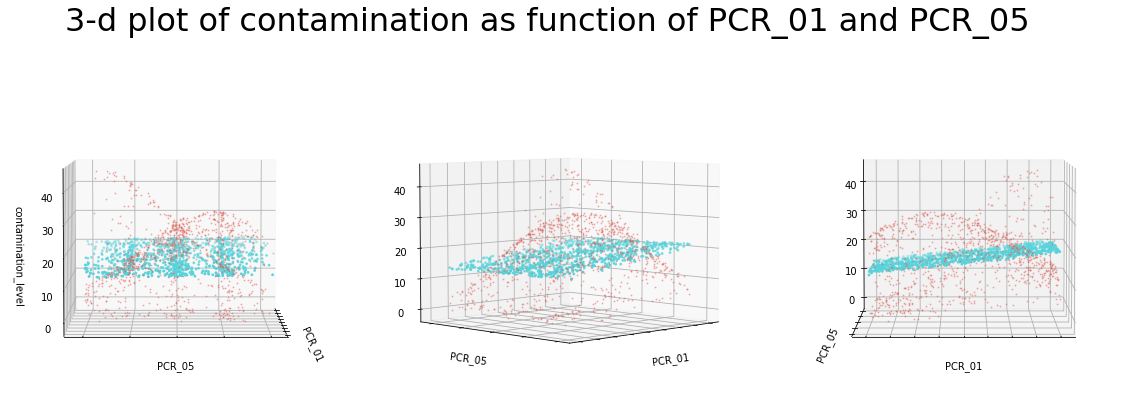

In [33]:
plot3d(train4,'PCR_01','PCR_05','contamination_level','3-d plot of contamination as function of PCR_01 and PCR_05',predictions=predictions_reg)

# Section 5 - Fitting Gradient Boosted Machines

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

features = ['PCR_01','PCR_02','PCR_03','PCR_04','PCR_05','PCR_09','PCR_10','sugar_levels','sport_activity']
target = 'contamination_level'
X_train = train[features]
Y_train = train[target]
X_test = test[features]
Y_test = test[target]

In [61]:
from sklearn.model_selection import GridSearchCV

loss_space = ['squared_error', 'absolute_error', 'huber']
# loss_space = ['squared_error']
lr_space = np.logspace(np.log10(0.237),np.log10(0.33),11)
# subsample_space = [0.3,0.5,0.8,1]
subsample_space = [0.5,0.8,1]
# subsample_space = [1]
min_samples_leaf_space = [22,24,25,26,27,30,33]

gs = GridSearchCV(GradientBoostingRegressor(), param_grid={'loss': loss_space, 'learning_rate': lr_space, 'subsample': subsample_space, 'min_samples_leaf': min_samples_leaf_space}, cv=5, return_train_score=True, scoring='neg_mean_squared_error')

gs.fit(X_train, Y_train)
cv_results = pd.DataFrame(gs.cv_results_)

In [94]:
best = cv_results.iloc[gs.best_index_]
print(best['params'])
print(best['mean_train_score'])
print(best['mean_test_score'])

{'learning_rate': 0.2705543889995741, 'loss': 'huber', 'min_samples_leaf': 26, 'subsample': 1}
-0.8292638662695315
-2.2571280451531726


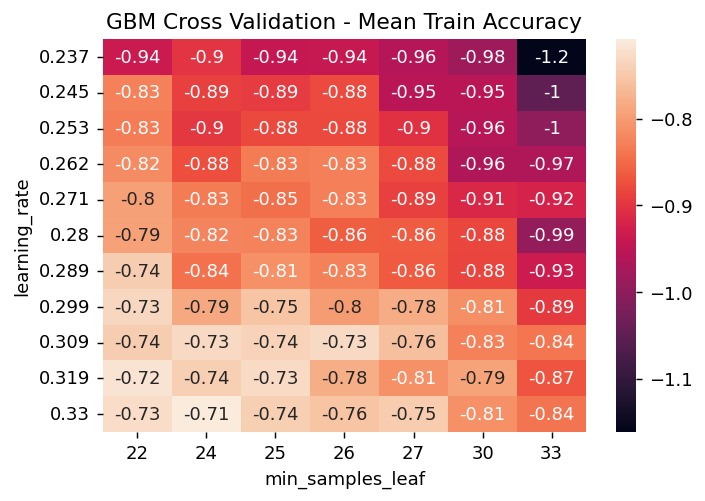

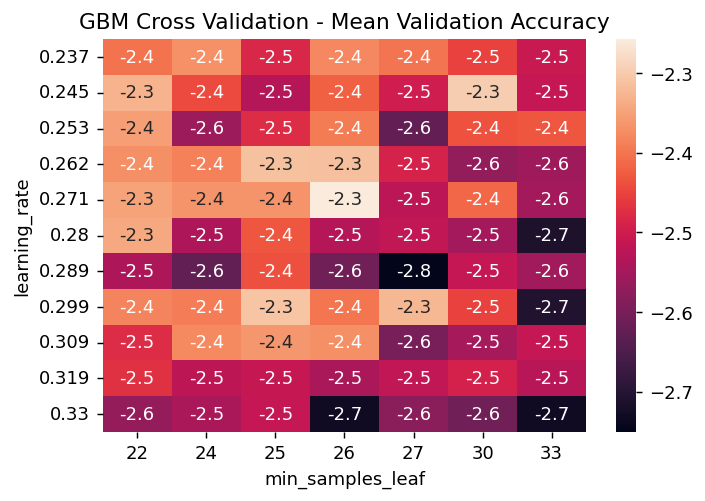

In [87]:
mean_train_score = cv_results.pivot_table(values='mean_train_score', index='param_learning_rate', columns='param_min_samples_leaf', aggfunc='max')
mean_test_score = cv_results.pivot_table(values='mean_test_score', index='param_learning_rate', columns='param_min_samples_leaf', aggfunc='max')

plt.figure(dpi=130)
sns.heatmap(mean_train_score, annot=True)
plt.xlabel('min_samples_leaf')
plt.ylabel('learning_rate')
ticks = plt.yticks()[1]
new_ticks = [str(round(float(tick.get_text()),3)) for tick in ticks]
plt.yticks(plt.yticks()[0], new_ticks)
plt.title('GBM Cross Validation - Mean Train Accuracy')
plt.show()
plt.figure(dpi=130)
sns.heatmap(mean_test_score, annot=True)
plt.xlabel('min_samples_leaf')
ticks = plt.yticks()[1]
new_ticks = [str(round(float(tick.get_text()),3)) for tick in ticks]
plt.yticks(plt.yticks()[0], new_ticks)
plt.ylabel('learning_rate')
plt.title('GBM Cross Validation - Mean Validation Accuracy')
plt.show()

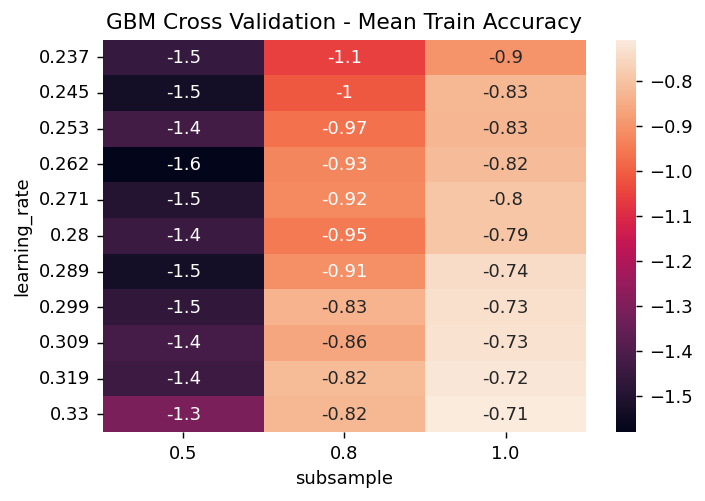

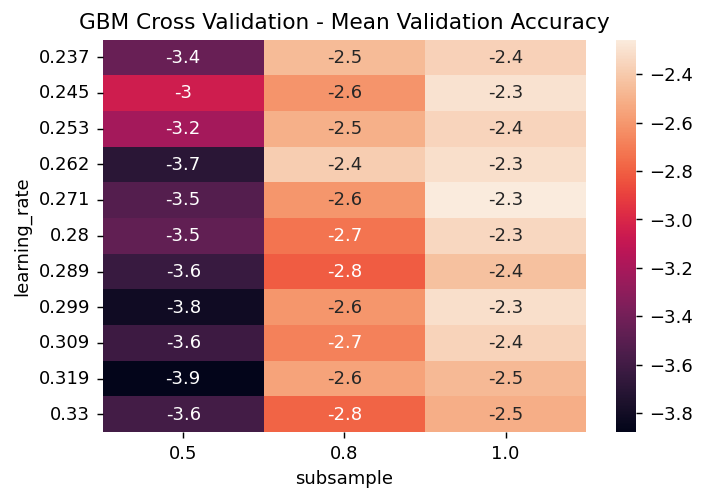

In [88]:
mean_train_score = cv_results.pivot_table(values='mean_train_score', index='param_learning_rate', columns='param_subsample', aggfunc='max')
mean_test_score = cv_results.pivot_table(values='mean_test_score', index='param_learning_rate', columns='param_subsample', aggfunc='max')

plt.figure(dpi=130)
sns.heatmap(mean_train_score, annot=True)
plt.xlabel('subsample')
plt.ylabel('learning_rate')
ticks = plt.yticks()[1]
new_ticks = [str(round(float(tick.get_text()),3)) for tick in ticks]
plt.yticks(plt.yticks()[0], new_ticks)
plt.title('GBM Cross Validation - Mean Train Accuracy')
plt.show()
plt.figure(dpi=130)
sns.heatmap(mean_test_score, annot=True)
plt.xlabel('subsample')
plt.ylabel('learning_rate')
ticks = plt.yticks()[1]
new_ticks = [str(round(float(tick.get_text()),3)) for tick in ticks]
plt.yticks(plt.yticks()[0], new_ticks)
plt.title('GBM Cross Validation - Mean Validation Accuracy')
plt.show()

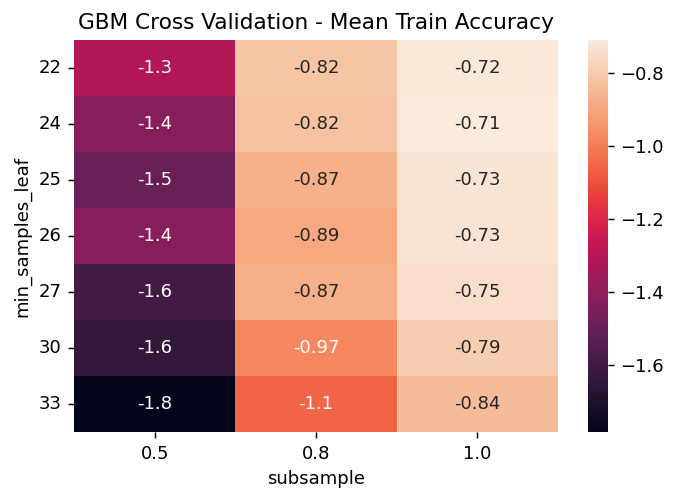

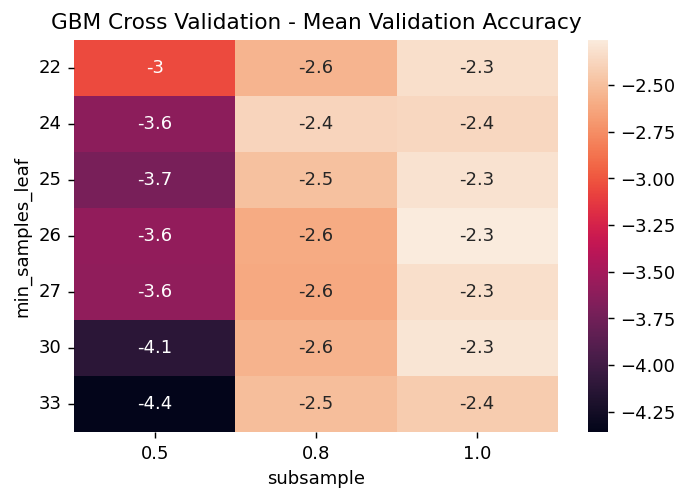

In [89]:
mean_train_score = cv_results.pivot_table(values='mean_train_score', index='param_min_samples_leaf', columns='param_subsample', aggfunc='max')
mean_test_score = cv_results.pivot_table(values='mean_test_score', index='param_min_samples_leaf', columns='param_subsample', aggfunc='max')

plt.figure(dpi=130)
sns.heatmap(mean_train_score, annot=True)
plt.xlabel('subsample')
plt.ylabel('min_samples_leaf')
plt.yticks(rotation=0)
plt.title('GBM Cross Validation - Mean Train Accuracy')
plt.show()
plt.figure(dpi=130)
sns.heatmap(mean_test_score, annot=True)
plt.xlabel('subsample')
plt.ylabel('min_samples_leaf')
plt.yticks(rotation=0)
plt.title('GBM Cross Validation - Mean Validation Accuracy')
plt.show()

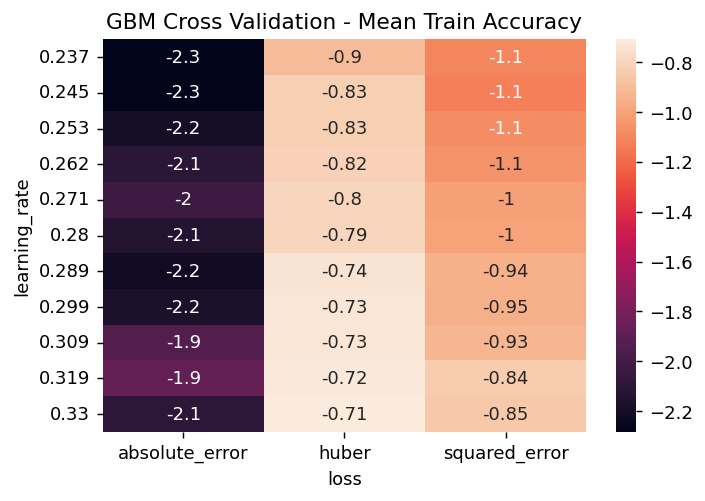

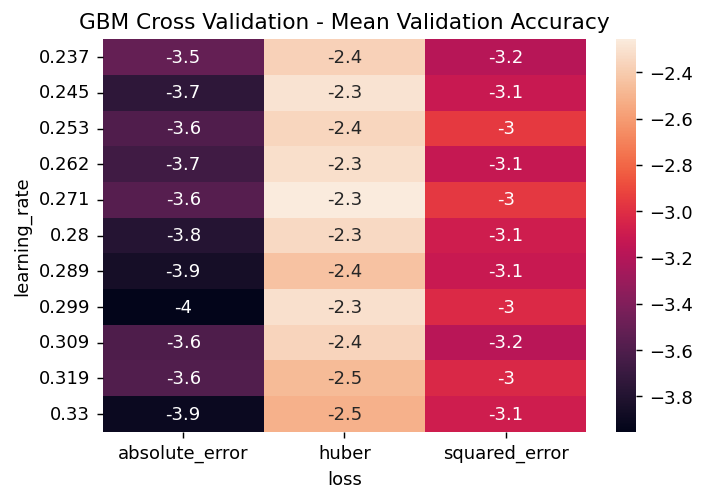

In [93]:
mean_train_score = cv_results.pivot_table(values='mean_train_score', index='param_learning_rate', columns='param_loss', aggfunc='max')
mean_test_score = cv_results.pivot_table(values='mean_test_score', index='param_learning_rate', columns='param_loss', aggfunc='max')

plt.figure(dpi=130)
sns.heatmap(mean_train_score, annot=True)
plt.xlabel('loss')
plt.ylabel('learning_rate')
ticks = plt.yticks()[1]
new_ticks = [str(round(float(tick.get_text()),3)) for tick in ticks]
plt.yticks(plt.yticks()[0], new_ticks)
plt.title('GBM Cross Validation - Mean Train Accuracy')
plt.show()
plt.figure(dpi=130)
sns.heatmap(mean_test_score, annot=True)
plt.xlabel('loss')
plt.ylabel('learning_rate')
ticks = plt.yticks()[1]
new_ticks = [str(round(float(tick.get_text()),3)) for tick in ticks]
plt.yticks(plt.yticks()[0], new_ticks)
plt.title('GBM Cross Validation - Mean Validation Accuracy')
plt.show()

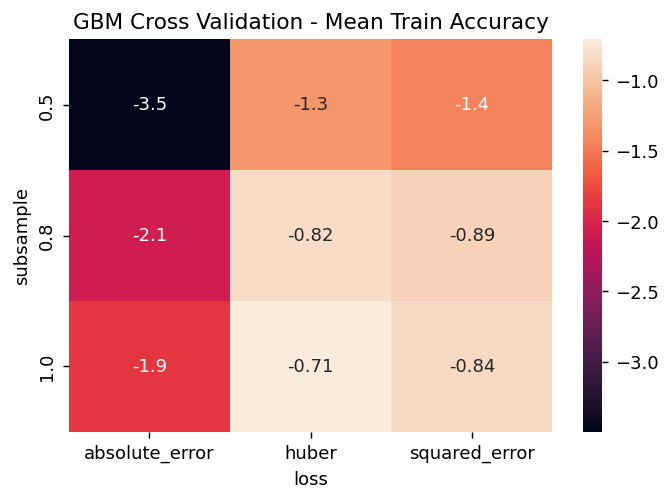

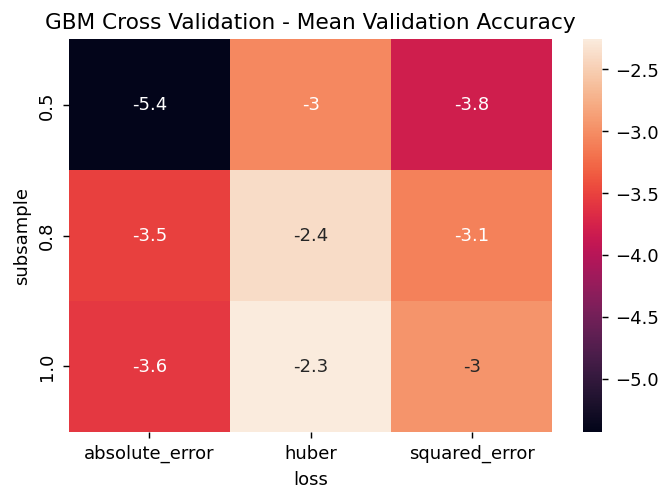

In [95]:
mean_train_score = cv_results.pivot_table(values='mean_train_score', index='param_subsample', columns='param_loss', aggfunc='max')
mean_test_score = cv_results.pivot_table(values='mean_test_score', index='param_subsample', columns='param_loss', aggfunc='max')

plt.figure(dpi=130)
sns.heatmap(mean_train_score, annot=True)
plt.xlabel('loss')
plt.ylabel('subsample')
plt.title('GBM Cross Validation - Mean Train Accuracy')
plt.show()
plt.figure(dpi=130)
sns.heatmap(mean_test_score, annot=True)
plt.xlabel('loss')
plt.ylabel('subsample')
plt.title('GBM Cross Validation - Mean Validation Accuracy')
plt.show()

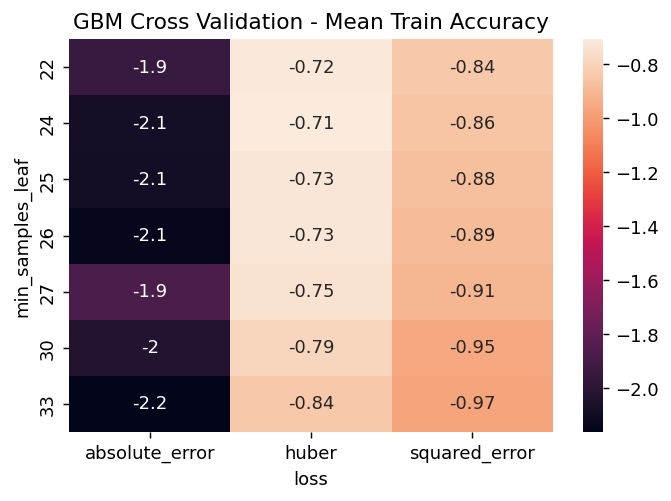

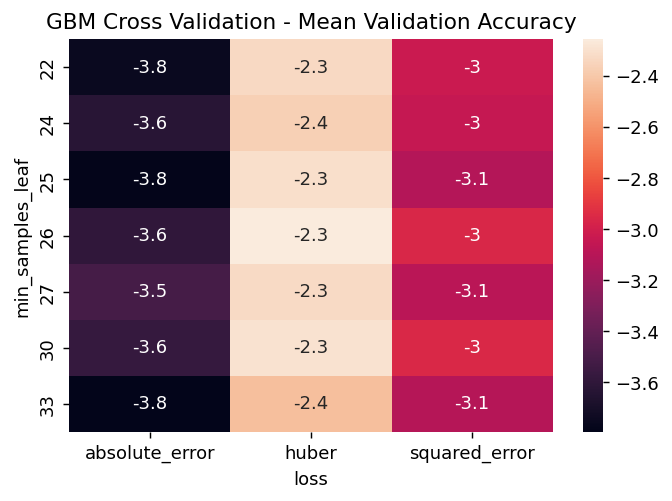

In [96]:
mean_train_score = cv_results.pivot_table(values='mean_train_score', index='param_min_samples_leaf', columns='param_loss', aggfunc='max')
mean_test_score = cv_results.pivot_table(values='mean_test_score', index='param_min_samples_leaf', columns='param_loss', aggfunc='max')

plt.figure(dpi=130)
sns.heatmap(mean_train_score, annot=True)
plt.xlabel('loss')
plt.ylabel('min_samples_leaf')
plt.title('GBM Cross Validation - Mean Train Accuracy')
plt.show()
plt.figure(dpi=130)
sns.heatmap(mean_test_score, annot=True)
plt.xlabel('loss')
plt.ylabel('min_samples_leaf')
plt.title('GBM Cross Validation - Mean Validation Accuracy')
plt.show()

In [98]:
best_bgm = GradientBoostingRegressor(**best['params'])
best_bgm.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.2705543889995741, loss='huber',
                          min_samples_leaf=26, subsample=1)

# Section 6 - Testing your models

In [151]:
X=test.iloc[:,0:-1].values
y=test['contamination_level'].values

print(1/len(y)*np.sum((dummy_regr.predict(X) - y)**2))
print(1/len(y)*np.sum((reg.predict(X) - y)**2))

110.33900596377768
99.41241495064


In [115]:
label = 'contamination_level'
X_train = train.drop(columns=[label])
Y_train = train[label]
X_test = test.drop(columns=[label])
Y_test = test[label]

print(1/len(Y_test)*np.sum((best_ridge.predict(X_test) - Y_test)**2))

93.91432482308132


In [130]:
test4=test[['PCR_01','PCR_05','contamination_level']].copy(deep=True)
X=test4[['PCR_01','PCR_05']].values
y=test4[['contamination_level']].values

print(1/len(y)*np.sum((poly_reg.predict(X) - y)**2))

83.71315870808216


In [117]:

features = ['PCR_01','PCR_02','PCR_03','PCR_04','PCR_05','PCR_09','PCR_10','sugar_levels','sport_activity']
target = 'contamination_level'
X_train = train[features]
Y_train = train[target]
X_test = test[features]
Y_test = test[target]

print(1/len(Y_test)*np.sum((best_bgm.predict(X_test) - Y_test)**2))

2.3246327544416334
